In [1]:
import glob
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from astropy import units as u 
from astropy.coordinates import SkyCoord
from gammapy.stats import WStatCountsStatistic
from magicctapipe.utils import (
    calc_angular_distance,
    check_tel_combination,
    get_dl2_mean,
)

In [2]:
# Display all columns of the pandas data frame:
pd.set_option('display.max_columns', None)

# Customize the pyplot figure:
plt.rcParams.update({
    'figure.figsize': (12, 9),
    'font.size': 15,
    'grid.linestyle': 'dotted',
})

# Get the default color cycle:
cls = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load DL2 data

### Load input files and apply quality cuts:

In [3]:
# === Settings ===
data_mask = '/home/yoshiki.ohtani/Crab/2020_12_15/4.dl1_to_dl2/data/dl2/merged/*.h5'
quality_cuts = 'intensity_width_2 < 0.2'

# === Main ===
print('Loading the following input files:')

file_paths = glob.glob(data_mask)
file_paths.sort()

data_list = []

for path in file_paths:
    
    print(Path(path).name)
    
    df = pd.read_hdf(path, 'events/parameters')
    data_list.append(df)
    
input_data = pd.concat(data_list)
input_data.set_index(['obs_id', 'event_id', 'tel_id'], inplace=True)
input_data.sort_index(inplace=True)

_ = check_tel_combination(input_data)

# print('Applying the quality cuts:')
# print(quality_cuts)

# input_data.query(quality_cuts, inplace=True)
# input_data['multiplicity'] = input_data.groupby(['obs_id', 'event_id']).size()
# input_data.query('multiplicity > 1', inplace=True)

# combo_types = check_tel_combination(input_data)
# input_data.update(combo_types)

Loading the following input files:
dl2_LST-1_MAGIC.Run03265.h5
dl2_LST-1_MAGIC.Run03266.h5
dl2_LST-1_MAGIC.Run03267.h5
dl2_LST-1_MAGIC.Run03268.h5



In total 572004 stereo events are found:
m1_m2 (type 0): 75252 events (13.2%)
lst1_m1 (type 1): 52159 events (9.1%)
lst1_m2 (type 2): 104431 events (18.3%)
lst1_m1_m2 (type 3): 340162 events (59.5%)


In [4]:
input_data.head(5)

obs_id_lst  event_id_lst   intensity         x  \
obs_id  event_id tel_id                                                   
5093711 1882     1           3265.0      213291.0  616.770799 -0.614440   
                 2              NaN           NaN  290.039062 -0.302226   
                 3              NaN           NaN  178.574219 -0.251598   
        1883     1           3265.0      213300.0   58.818809 -0.174262   
                 3              NaN           NaN   68.593750 -0.040102   

                                y         r         phi    length  \
obs_id  event_id tel_id                                             
5093711 1882     1       0.126402  0.627307  168.375310  0.075044   
                 2       0.111699  0.322207  159.716245  0.052958   
                 3       0.071062  0.261441  164.228178  0.148567   
        1883     1      -0.365458  0.404879 -115.493274  0.030408   
                 3      -0.245073  0.248332  -99.293091  0.020853   

                         length_uncertainty     width  width_uncertainty  \
obs_id  event_id tel_id                                                    
5093711 1882     1                 0.003698  0.044855           0.002338   
                 2                 0.001560  0.030104           0.001145   
                 3                 0.006885  0.030572           0.001377   
        1883     1                 0.003927  0.025406           0.006412   
                 3                 0.001948  0.019717           0.001183   

                               psi  skewness  kurtosis      slope  intercept  \
obs_id  event_id tel_id                                                        
5093711 1882     1      -11.082300 -0.472252  2.430343  -5.715335  16.691730   
                 2      -28.351680  0.022468  2.006568  -8.048335  24.880157   
                 3       12.571635  1.150621  2.533926 -15.539467  27.215714   
        1883     1      -39.846270  0.345721  1.936949  -7.442740  15.337474   
                 3      -44.689152  0.599909  3.394796  16.288925  23.731348   

                         intensity_width_1  intensity_width_2  pixels_width_1  \
obs_id  event_id tel_id                                                         
5093711 1882     1                     0.0                0.0             0.0   
                 2                     0.0                0.0             0.0   
                 3                     0.0                0.0             0.0   
        1883     1                     0.0                0.0             0.0   
                 3                     0.0                0.0             0.0   

                         pixels_width_2  n_pixels  n_islands  pointing_alt  \
obs_id  event_id tel_id                                                      
5093711 1882     1                  0.0        27          1      0.699055   
                 2                  0.0        30          1      0.698988   
                 3                  0.0        22          2      0.698982   
        1883     1                  0.0         5          1      0.699055   
                 3                  0.0         8          1      0.698982   

                         pointing_az     timestamp  multiplicity  combo_type  \
obs_id  event_id tel_id                                                        
5093711 1882     1          1.467483  1.608068e+09             3         3.0   
                 2          1.467507  1.608068e+09             3         3.0   
                 3          1.467476  1.608068e+09             3         3.0   
        1883     1          1.467483  1.608068e+09             2         2.0   
                 3          1.467476  1.608068e+09             2         2.0   

                                h_max        alt  alt_uncert         az  \
obs_id  event_id tel_id                                                   
5093711 1882     1       10561.897828  39.217146    0.176466  84.347541   
                 2  

### Compute the mean of the DL2 parameters:

In [5]:
print('Computing the mean of the DL2 parameters...')
dl2_mean = get_dl2_mean(input_data)

print(f'--> Number of events: {len(dl2_mean)}')

Computing the mean of the DL2 parameters...
--> Number of events: 572004


In [6]:
dl2_mean.head()

combo_type  gammaness  reco_energy   reco_alt    reco_az  \
obs_id  event_id                                                             
5093711 1882             3.0   0.352000     0.396424  39.914487  84.435082   
        1883             2.0   0.320250     0.093016  40.344065  82.399187   
        1884             2.0   0.630631     0.119178  41.082453  82.842410   
        1885             3.0   0.004444     0.154091  39.505055  84.447390   
        1886             0.0   0.107143     0.463404  41.421144  84.540749   

                  pointing_alt  pointing_az    reco_ra   reco_dec  \
obs_id  event_id                                                    
5093711 1882          0.699008     1.467489  84.004650  21.946709   
        1883          0.699018     1.467480  84.115719  23.558233   
        1884          0.699020     1.467480  83.236067  23.472478   
        1885          0.699010     1.467490  84.416472  21.799255   
        1886          0.698987     1.467493  82.441862  22.372530   

                  pointing_ra  pointing_dec     timestamp  
obs_id  event_id                                           
5093711 1882        83.964756     22.247877  1.608068e+09  
        1883        83.964313     22.248447  1.608068e+09  
        1884        83.964314     22.248441  1.608068e+09  
        1885        83.964756     22.247873  1.608068e+09  
        1886        83.966074     22.247311  1.608068e+09

### Check the observation time:

In [7]:
times_first = dl2_mean.groupby(['obs_id'])['timestamp'].first()
times_last = dl2_mean.groupby(['obs_id'])['timestamp'].last()

obs_time = u.Quantity(np.sum(times_last - times_first), u.s)
print(f'Observation time: {obs_time.to(u.min):.2f}')

Observation time: 55.07 min


# Compute the angular distance from ON/OFF regions

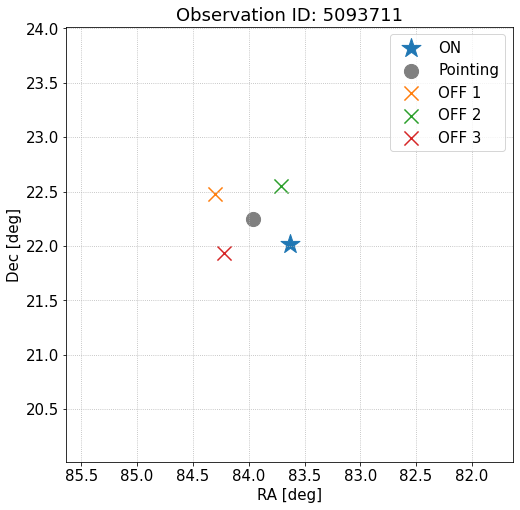

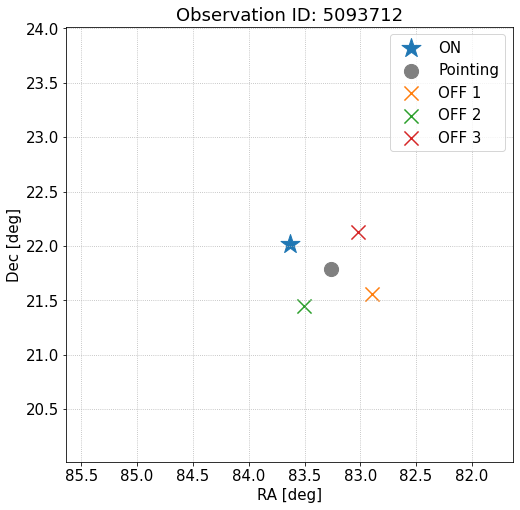

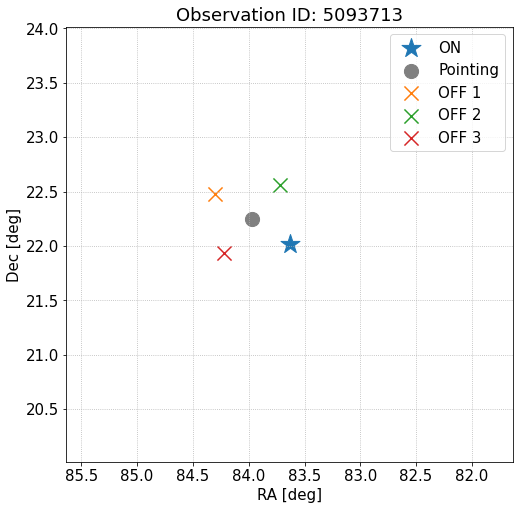

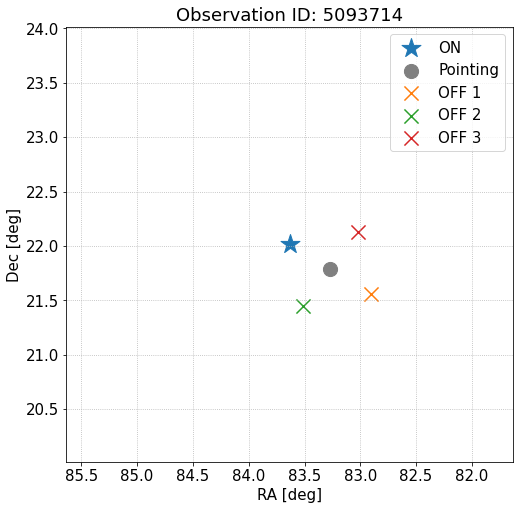

In [8]:
# === Settings ===
source_name = 'Crab'
n_off_regions = 3

# === Main ===
on_coord = SkyCoord.from_name(source_name)
on_coord = on_coord.transform_to('icrs')

xlim = [on_coord.ra.value + 2, on_coord.ra.value - 2]
ylim = [on_coord.dec.value - 2, on_coord.dec.value + 2]

observation_ids = np.unique(dl2_mean.index.get_level_values('obs_id'))

for obs_id in observation_ids:
    
    df_obs = dl2_mean.query(f'obs_id == {obs_id}')
    
    event_coords = SkyCoord(
        ra=u.Quantity(df_obs['reco_ra'].to_numpy(), u.deg),
        dec=u.Quantity(df_obs['reco_dec'].to_numpy(), u.deg),
        frame='icrs',
    )
    
    tel_coords = SkyCoord(
        ra=u.Quantity(df_obs['pointing_ra'].to_numpy(), u.deg),
        dec=u.Quantity(df_obs['pointing_dec'].to_numpy(), u.deg),
        frame='icrs',
    )
    
    # Compute the angular distance from ON/OFF regions:
    theta_on, theta_off, off_coords = calc_angular_distance(
        on_coord, event_coords, tel_coords, n_off_regions,
    )
    
    dl2_mean.loc[(obs_id, slice(None)), 'theta2_on'] = theta_on.to(u.deg).value ** 2
    
    for i_off in theta_off.keys():
        dl2_mean.loc[(obs_id, slice(None)), f'theta2_off{i_off}'] = theta_off[i_off].to(u.deg).value ** 2
        
    # Plot the ON/OFF positions:
    plt.figure(figsize=(8, 8))
    plt.title(f'Observation ID: {obs_id}')
    plt.xlabel('RA [deg]')
    plt.ylabel('Dec [deg]')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.axis(xlim+ylim)

    plt.scatter(
        on_coord.ra.value, on_coord.dec.value,
        label='ON', marker='*', s=400,
    )

    plt.scatter(
        tel_coords.ra.mean().value, tel_coords.dec.mean().value,
        label='Pointing', marker='o', s=200, color='grey',
    )
    
    for i_off in off_coords.keys():
        plt.scatter(
            off_coords[i_off].ra.value, off_coords[i_off].dec.value, 
            label=f'OFF {i_off}', marker='x', s=200, color=cls[i_off],
        )
    
    plt.grid()
    plt.legend()

    plt.show()
    plt.close()
    

# Check a signal from the source

### Count map:

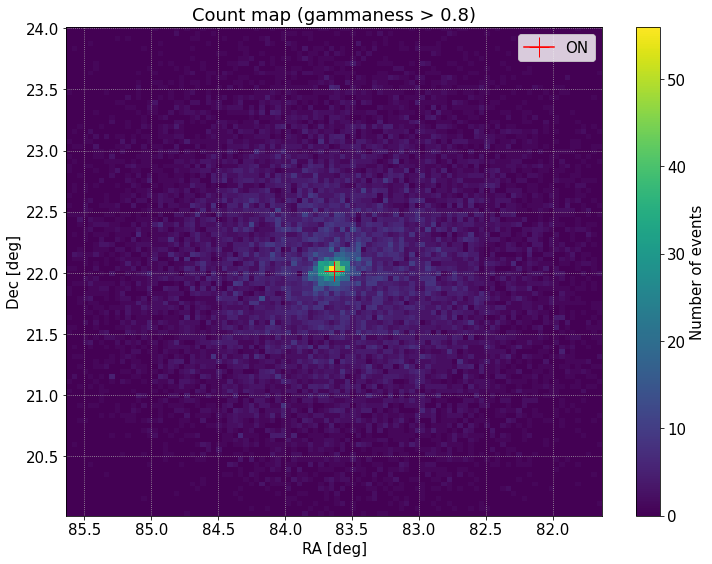

In [9]:
# === Settings ===
roi = 2
gam_cut = 0.8

# === Main ===
df = dl2_mean.query(f'gammaness > {gam_cut}')

xlim = [on_coord.ra.value + roi, on_coord.ra.value - roi]
ylim = [on_coord.dec.value - roi, on_coord.dec.value + roi]

plt.figure()
plt.title(f'Count map (gammaness > {gam_cut})')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.xlim(xlim)
plt.ylim(ylim)

plt.hist2d(
    df['reco_ra'].to_numpy(), df['reco_dec'].to_numpy(),
    bins=[np.linspace(xlim[1], xlim[0], 101), np.linspace(ylim[0], ylim[1], 101)],
)

plt.plot(
    on_coord.ra.value, on_coord.dec.value, 
    marker='+', markersize=20, color='red', label='ON',
)

plt.axis(xlim+ylim)
plt.colorbar(label='Number of events')

plt.grid()
plt.legend()
plt.show()

### Theta2 distribution:

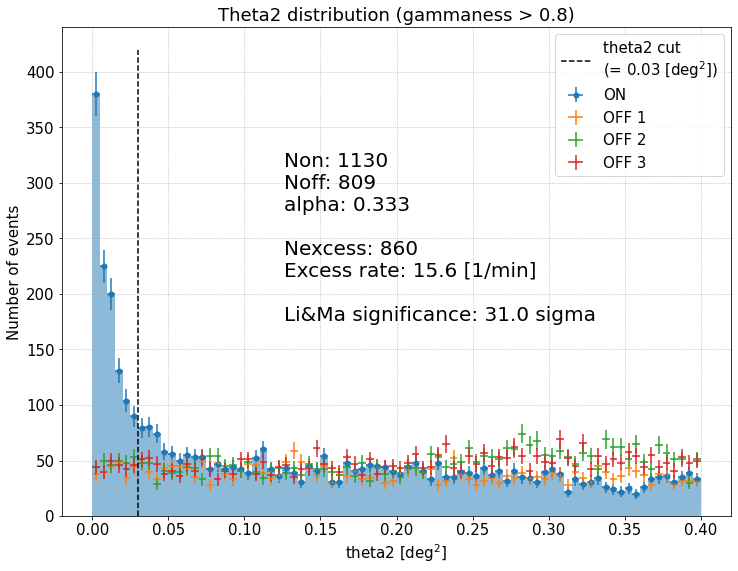

In [10]:
# === Settings ===
combo_types = [3]
bins_t2 = np.linspace(0, 0.4, 81)

gam_cut = 0.8
t2_cut = 0.03

# === Main ===
bins_t2_center = (bins_t2[:-1] + bins_t2[1:]) / 2
xerr = [bins_t2_center - bins_t2[:-1], bins_t2[1:] - bins_t2_center]

df = dl2_mean.query(f'(combo_type == {combo_types}) & (gammaness > {gam_cut})')

plt.figure()
plt.title(f'Theta2 distribution (gammaness > {gam_cut})')
plt.xlabel('theta2 [deg$^2$]')
plt.ylabel('Number of events')

# Theta2 from the ON region:
hist_on = plt.hist(
    df['theta2_on'].to_numpy(), bins=bins_t2,
    histtype='bar', linewidth=2, alpha=0.5,
)

plt.errorbar(
    x=bins_t2_center, y=hist_on[0], xerr=xerr, yerr=np.sqrt(hist_on[0]), 
    fmt='o', markersize=5, label='ON', color=cls[0],
)

# Theta2 from the OFF regions:
for i_off in range(n_off_regions):
    
    hist_off, _ = np.histogram(
        df[f'theta2_off{i_off+1}'].to_numpy(), bins=bins_t2,
    )
    
    plt.errorbar(
        x=bins_t2_center, y=hist_off, xerr=xerr, yerr=np.sqrt(hist_off), 
        fmt='o', markersize=1, label=f'OFF {i_off+1}',
    )
    
plt.plot(
    (t2_cut, t2_cut), (0, plt.ylim()[1]), 
    linestyle='--', color='black', label=f'theta2 cut\n(= {t2_cut} [deg$^2$])',
)

# Compute the significance:
n_on = len(df.query(f'theta2_on < {t2_cut}'))
n_off = np.sum([len(df.query(f'theta2_off{i_off+1} < {t2_cut}')) for i_off in range(n_off_regions)])

alpha = 1 / n_off_regions
n_excess = n_on - alpha * n_off
excess_rate = n_excess / obs_time.to(u.min).value

stat = WStatCountsStatistic(n_on, n_off, alpha=alpha)
significance = stat.sqrt_ts

text = f'Non: {n_on}\nNoff: {n_off}\nalpha: {alpha:.3f}' \
       f'\n\nNexcess: {n_excess:.0f}\nExcess rate: {excess_rate:.1f} [1/min]' \
       f'\n\nLi&Ma significance: {significance:.1f} sigma'

plt.text(0.3*plt.xlim()[1], 0.4*plt.ylim()[1], text, fontsize=20)

plt.grid()
plt.legend()
plt.show()

### Theta2 distribution in each energy bin:

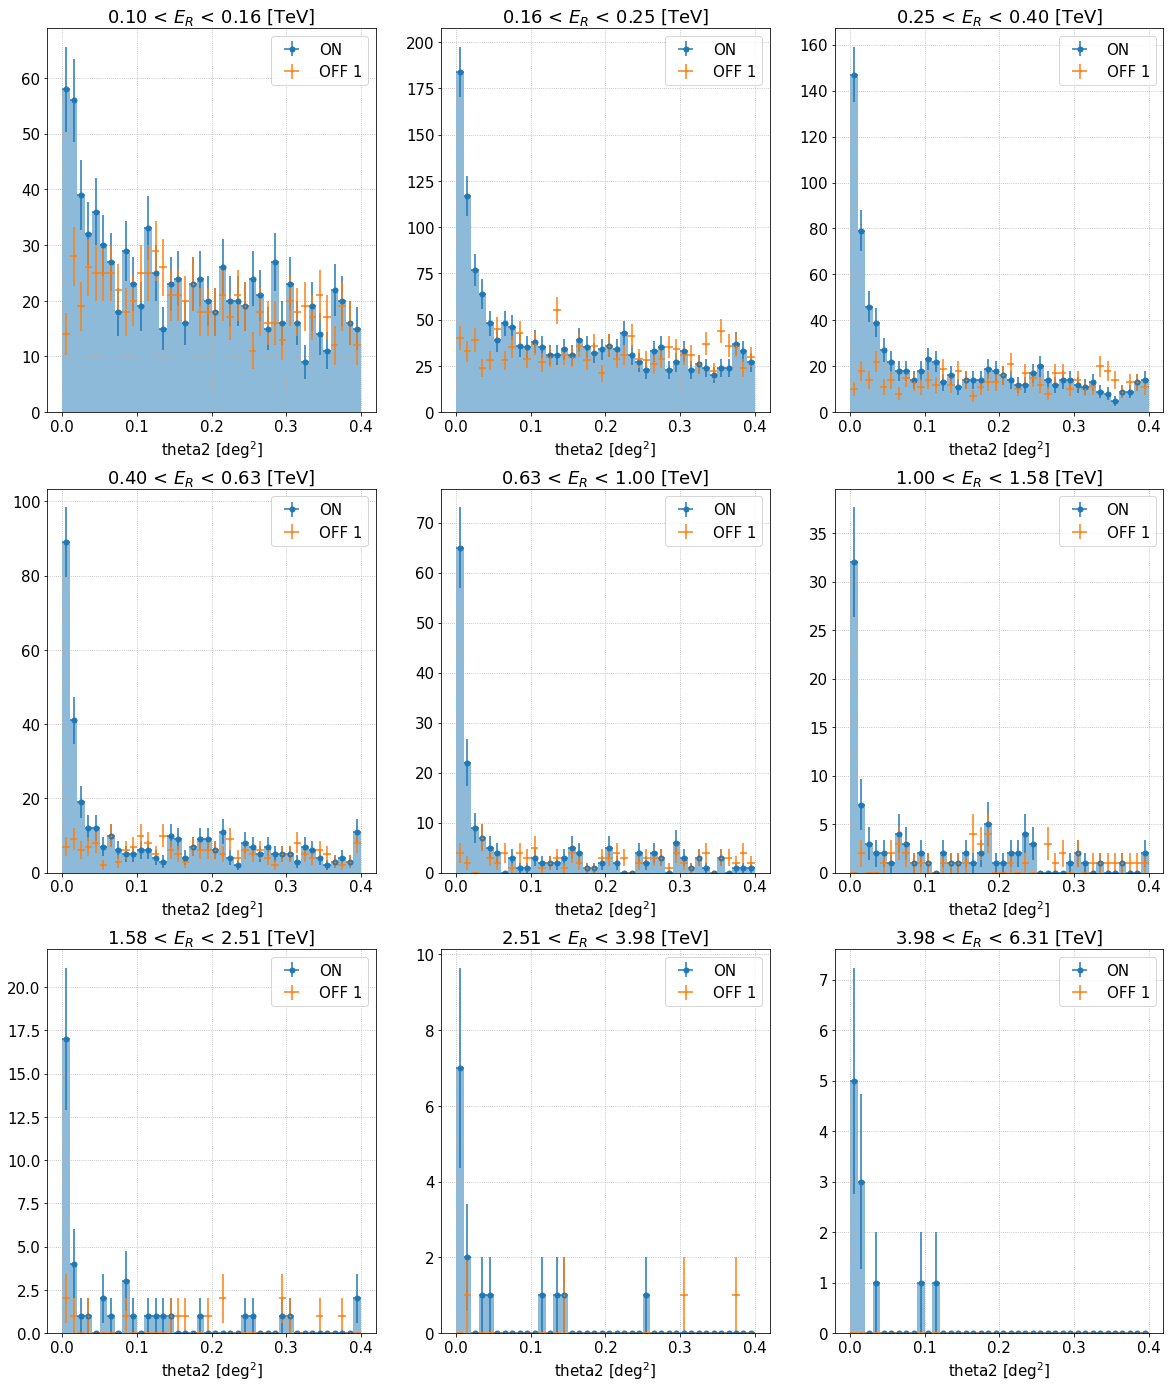

In [11]:
# === Settings ===
combo_types = [3]
gam_cut = 0.8

bins_eng = np.logspace(-1, 1, 11)[:-1]
bins_t2 = np.linspace(0, 0.4, 41)

figsize = (20, 24)

# === Main ===
bins_t2_center = (bins_t2[:-1] + bins_t2[1:]) / 2
xerr = [bins_t2_center - bins_t2[:-1], bins_t2[1:] - bins_t2_center]

plt.figure(figsize=figsize)

grid = (int(np.ceil(len(bins_eng[:-1])/3)), 3)
locs = list(itertools.product(range(grid[0]), range(grid[1])))

for i_bin, (eng_lolim, eng_uplim) in enumerate(zip(bins_eng[:-1], bins_eng[1:])):
    
    event_cuts = f'(combo_type == {combo_types}) & (gammaness > {gam_cut}) ' \
                 f'& (reco_energy > {eng_lolim}) & (reco_energy < {eng_uplim})'
    
    df = dl2_mean.query(event_cuts)
    
    plt.subplot2grid(grid, locs[i_bin])
    plt.title(rf'{eng_lolim:.2f} < $E_R$ < {eng_uplim:.2f} [TeV]')
    plt.xlabel('theta2 [deg$^2$]')

    if len(df) > 0:

        hist_on = plt.hist(
            df['theta2_on'].to_numpy(), bins=bins_t2,
            histtype='bar', linewidth=2, alpha=0.5,
        )

        plt.errorbar(
            x=bins_t2_center, y=hist_on[0], xerr=xerr, yerr=np.sqrt(hist_on[0]), 
            fmt='o', markersize=5, label='ON', color=cls[0],
        )

        hist_off, _ = np.histogram(
            df['theta2_off1'].to_numpy(), bins=bins_t2,
        )

        plt.errorbar(
            x=bins_t2_center, y=hist_off, xerr=xerr, yerr=np.sqrt(hist_off), 
            fmt='o', markersize=1, label=f'OFF 1',
        )

        plt.legend(loc='upper right')
        plt.grid()
    
plt.show()